# VoxelMorph Tutorial : 2D MRI Example

## Jinyeong KIM

##### Reference : https://colab.research.google.com/drive/1WiqyF7dCdnNBIANEY80Pxw_mVz4fyV-S?usp=sharing#scrollTo=hDzrcDyTPXNm

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn")
import tensorflow as tf
import voxelmorph as vxm #registration
import neurite as ne #medical image analysis

## 1. Data Check

In [2]:
# From https://surfer.nmr.mgh.harvard.edu/pub/data/voxelmorph/tutorial_data.tar.gz
tutorial_np = np.load('./data/tutorial_data.npz')
x_train = tutorial_np['train']
x_val = tutorial_np['validate']

# Check Shape
input_shape = x_train.shape[1:]
print ("Train Shape : {}, Test Shape : {}".format(x_train.shape, x_val.shape))

Train Shape : (208, 192, 160), Test Shape : (141, 192, 160)


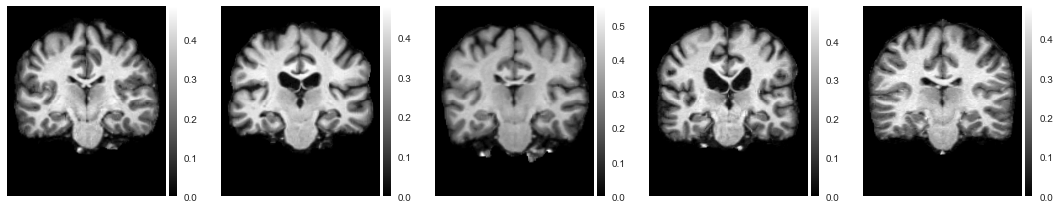

(<Figure size 1080x216 with 10 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>], dtype=object))

In [3]:
# Visualization
idx_vis_num = 5
idx = np.random.randint(x_train.shape[0], size=idx_vis_num)
ne.plot.slices([sample for sample in x_train[idx]], cmaps=['gray'], do_colorbars=True)

In [4]:
# Data Generator Function
def vxm_data_generator(x_data, batch_size=32):
    # Data : [M, H, W]
    
    # Generation
    # Input : moving-img [N, H, W, 1], fixed-img [N, H, W, 1]
    # Output : moved-img [N, H, W, 1], zero-grad [N, H, W, 2]
    
    # preliminary sizing
    vol_shape = x_data.shape[1:] # extract data shape
    ndims = len(vol_shape)
    
    # prepare a zero array the size of the deformation
    zero_phi = np.zeros([batch_size, *vol_shape, ndims])
    
    while True:
        # prepare inputs:
        # images need to be of the size [N, H, W, 1]
        idx1 = np.random.randint(0, x_data.shape[0], size=batch_size)
        moving_images = x_data[idx1, ..., np.newaxis]
        idx2 = np.random.randint(0, x_data.shape[0], size=batch_size)
        fixed_images = x_data[idx2, ..., np.newaxis]
        inputs = [moving_images, fixed_images]
        
        # prepare outputs (the 'true' moved image):
        # fixed_images : not used, just dummy data
        outputs = [fixed_images, zero_phi]
        
        yield (inputs, outputs)

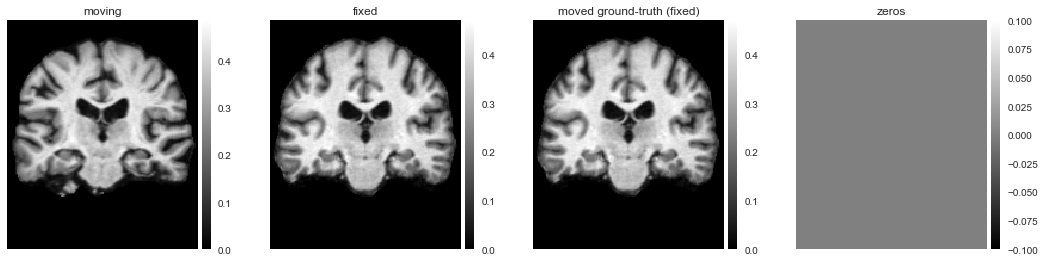

In [5]:
# Data Generator Definition
train_generator = vxm_data_generator(x_train, batch_size=8)
in_sample, out_sample = next(train_generator)

# visualize
images = [img[0, :, :, 0] for img in in_sample + out_sample]
titles = ['moving', 'fixed', 'moved ground-truth (fixed)', 'zeros']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

## 2. Model Generation

In [6]:
# U-Net based unsupervised model (VxmDense)
# nb_features : unet convolutional features
# int_steps : number of flow integration steps; 0 = disables diffeomorphism
nb_features = [
    [32, 32, 32, 32],           # Encoder Features
    [32, 32, 32, 32, 32, 16]    # Decoder Features
]
model = vxm.networks.VxmDense(input_shape, nb_features, int_steps=0)

# Losses
# 'mse' : Similarity
# Grad('l2') : Regularization
losses = ['mse', vxm.losses.Grad('l2').loss]
lambda_param = 0.01
loss_weights = [1, lambda_param]

Instructions for updating:
Use fn_output_signature instead


In [7]:
# Complie (tensorflow-like)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=losses,
              loss_weights=loss_weights)

## 3.  Training

In [8]:
# Use fit_generator instead of fit; 'fit' requires all the data to be in a big array
hist = model.fit_generator(train_generator, epochs=200, steps_per_epoch=5, verbose=2)

c:\users\jinyo\miniconda3\envs\tensorflow\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/200
5/5 - 4s - loss: 0.0065 - transformer_loss: 0.0065 - flow_loss: 7.6991e-08
Epoch 2/200
5/5 - 0s - loss: 0.0072 - transformer_loss: 0.0072 - flow_loss: 9.1835e-07
Epoch 3/200
5/5 - 0s - loss: 0.0069 - transformer_loss: 0.0069 - flow_loss: 4.1472e-06
Epoch 4/200
5/5 - 0s - loss: 0.0071 - transformer_loss: 0.0071 - flow_loss: 1.5941e-05
Epoch 5/200
5/5 - 0s - loss: 0.0067 - transformer_loss: 0.0067 - flow_loss: 5.3916e-05
Epoch 6/200
5/5 - 0s - loss: 0.0068 - transformer_loss: 0.0068 - flow_loss: 9.4281e-05
Epoch 7/200
5/5 - 0s - loss: 0.0073 - transformer_loss: 0.0073 - flow_loss: 7.1686e-05
Epoch 8/200
5/5 - 0s - loss: 0.0073 - transformer_loss: 0.0073 - flow_loss: 4.9940e-05
Epoch 9/200
5/5 - 0s - loss: 0.0066 - transformer_loss: 0.0066 - flow_loss: 4.9820e-05
Epoch 10/200
5/5 - 0s - loss: 0.0071 - transformer_loss: 0.0071 - flow_loss: 6.0040e-05
Epoch 11/200
5/5 - 0s - loss: 0.0061 - transformer_loss: 0.0061 - flow_loss: 7.3405e-05
Epoch 12/200
5/5 - 0s - loss: 0.0069 - tr

Epoch 98/200
5/5 - 0s - loss: 0.0039 - transformer_loss: 0.0035 - flow_loss: 0.0494
Epoch 99/200
5/5 - 0s - loss: 0.0037 - transformer_loss: 0.0032 - flow_loss: 0.0488
Epoch 100/200
5/5 - 0s - loss: 0.0036 - transformer_loss: 0.0032 - flow_loss: 0.0491
Epoch 101/200
5/5 - 0s - loss: 0.0039 - transformer_loss: 0.0034 - flow_loss: 0.0529
Epoch 102/200
5/5 - 0s - loss: 0.0042 - transformer_loss: 0.0037 - flow_loss: 0.0515
Epoch 103/200
5/5 - 0s - loss: 0.0040 - transformer_loss: 0.0035 - flow_loss: 0.0512
Epoch 104/200
5/5 - 0s - loss: 0.0038 - transformer_loss: 0.0033 - flow_loss: 0.0536
Epoch 105/200
5/5 - 0s - loss: 0.0037 - transformer_loss: 0.0032 - flow_loss: 0.0535
Epoch 106/200
5/5 - 0s - loss: 0.0040 - transformer_loss: 0.0034 - flow_loss: 0.0579
Epoch 107/200
5/5 - 0s - loss: 0.0040 - transformer_loss: 0.0034 - flow_loss: 0.0581
Epoch 108/200
5/5 - 0s - loss: 0.0036 - transformer_loss: 0.0031 - flow_loss: 0.0504
Epoch 109/200
5/5 - 0s - loss: 0.0037 - transformer_loss: 0.0032 - 

Epoch 195/200
5/5 - 0s - loss: 0.0027 - transformer_loss: 0.0021 - flow_loss: 0.0614
Epoch 196/200
5/5 - 0s - loss: 0.0032 - transformer_loss: 0.0024 - flow_loss: 0.0721
Epoch 197/200
5/5 - 0s - loss: 0.0031 - transformer_loss: 0.0024 - flow_loss: 0.0706
Epoch 198/200
5/5 - 0s - loss: 0.0031 - transformer_loss: 0.0024 - flow_loss: 0.0701
Epoch 199/200
5/5 - 0s - loss: 0.0031 - transformer_loss: 0.0024 - flow_loss: 0.0711
Epoch 200/200
5/5 - 0s - loss: 0.0027 - transformer_loss: 0.0020 - flow_loss: 0.0624


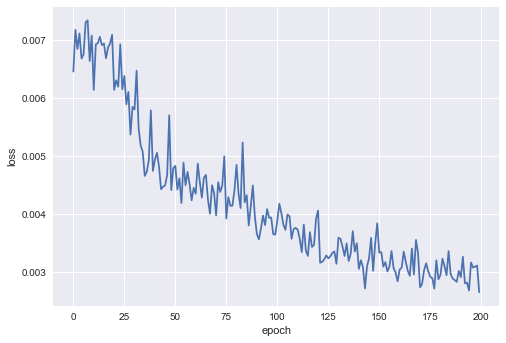

In [9]:
# Loss Plot
train_loss = hist.history['loss']
plt.figure()
plt.plot(train_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

## 4. Validation

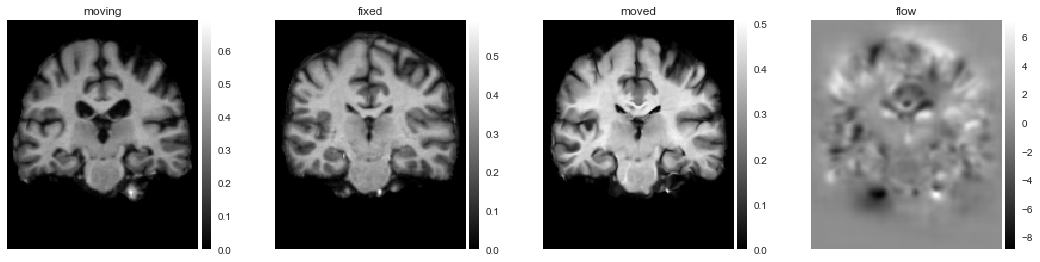

In [10]:
# Validation Generator Definition
val_generator = vxm_data_generator(x_val, batch_size=1)
val_input, _ = next(val_generator)

# Prediction
val_pred = model.predict(val_input)

# Visualization
images = [img[0, :, :, 0] for img in val_input + val_pred] 
titles = ['moving', 'fixed', 'moved', 'flow']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);